# Download all libraries

In [ ]:
pip install -r requirements.txt

In [6]:
import cv2
print("OpenCV version:", cv2.__version__)

import numpy as np
print("NumPy version:", np.__version__)

from PIL import Image
print("PIL version:", Image.__version__)

import pandas as pd
print("Pandas version:", pd.__version__)

import tensorflow as tf
print("TensorFlow version:", tf.__version__)

import keras
print("keras version:", keras.__version__)

import sklearn
print("sklearn version:", sklearn.__version__)

OpenCV version: 4.6.0
NumPy version: 1.25.1
PIL version: 9.0.1
Pandas version: 1.4.2
TensorFlow version: 2.10.1
keras version: 2.10.0
sklearn version: 1.0.2


# Add all necessary libraries

In [1]:
import cv2
import numpy as np
from PIL import Image
import random
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.model_selection import train_test_split
import glob

%matplotlib inline

In [2]:
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")
os.environ["CUDA_VISIBLE_DEVICES"]="0,1" 

GPU is available


In [3]:
!nvidia-smi

Sun Jan 21 20:53:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.23                 Driver Version: 536.23       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A4500             WDDM  | 00000000:01:00.0 Off |                  Off |
| 30%   30C    P8              11W / 200W |      0MiB / 20470MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Build model

In [11]:
# 訓練集資料路徑
DATASET_PATH  = r"D:\231219 MAP\231219 GF1"

# 影像大小
IMAGE_SIZE = (224, 224)

# 影像類別數
NUM_CLASSES = 2

# 若 GPU 記憶體不足，可調降 batch size 或凍結更多層網路
BATCH_SIZE = 16

# 凍結網路層數
FREEZE_LAYERS = 2

# Epoch 數
NUM_EPOCHS = 100

# 命名模型輸出儲存的檔案
WEIGHTS_FINAL = 'GF1_model5_resnet50_0122.h5'
checkpoint = ModelCheckpoint(WEIGHTS_FINAL, monitor='val_loss', verbose=1, save_best_only=True)
callbacks_list = [checkpoint]

# 透過 data augmentation 產生訓練與驗證用的影像資料
train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_batches = train_datagen.flow_from_directory(DATASET_PATH + '/train',
                                                  target_size=IMAGE_SIZE,
                                                  #interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)

valid_datagen = ImageDataGenerator()
valid_batches = valid_datagen.flow_from_directory(DATASET_PATH + '/valid',
                                                  target_size=IMAGE_SIZE,
                                                  #interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)

# 輸出各類別的索引值
for cls, idx in train_batches.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))

# 以訓練好的 ResNet50 為基礎來建立模型，
# 捨棄 ResNet50 頂層的 fully connected layers
net = ResNet50(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
x = net.output
x = Flatten()(x)

# 增加 DropOut layer
x = Dropout(0.5)(x)

# 增加 Dense layer，以 softmax 產生個類別的機率值
output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)

# 設定凍結與要進行訓練的網路層
net_final = Model(inputs=net.input, outputs=output_layer)
for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True

# 使用 Adam optimizer，以較低的 learning rate 進行 fine-tuning
net_final.compile(optimizer=Adam(learning_rate=2e-5),
                  loss='categorical_crossentropy', metrics=['accuracy'])

# 輸出整個網路結構
print(net_final.summary())


# 訓練模型
hist = net_final.fit(train_batches,
                        steps_per_epoch = train_batches.samples // BATCH_SIZE,
                        validation_data = valid_batches,
                        validation_steps = valid_batches.samples // BATCH_SIZE,
                        epochs = NUM_EPOCHS,
                        callbacks=callbacks_list).history

Found 108 images belonging to 2 classes.
Found 26 images belonging to 2 classes.
Class #0 = not reworkable
Class #1 = reworkable


C:\Users\user\AppData\Local\Temp\ipykernel_18084\3293654075.py:89: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = net_final.fit_generator(train_batches,


Epoch 1/100
6/6 [==============================] - ETA: 0s - loss: 1.7260 - accuracy: 0.5109
Epoch 1: val_loss improved from inf to 0.64592, saving model to GF1_model5_resnet50_0122.h5
6/6 [==============================] - 6s 426ms/step - loss: 1.7260 - accuracy: 0.5109 - val_loss: 0.6459 - val_accuracy: 0.6250
Epoch 2/100
6/6 [==============================] - ETA: 0s - loss: 1.3406 - accuracy: 0.5761
Epoch 2: val_loss improved from 0.64592 to 0.63234, saving model to GF1_model5_resnet50_0122.h5
6/6 [==============================] - 2s 269ms/step - loss: 1.3406 - accuracy: 0.5761 - val_loss: 0.6323 - val_accuracy: 0.5625
Epoch 3/100
6/6 [==============================] - ETA: 0s - loss: 1.6308 - accuracy: 0.5109
Epoch 3: val_loss did not improve from 0.63234
6/6 [==============================] - 1s 151ms/step - loss: 1.6308 - accuracy: 0.5109 - val_loss: 0.8135 - val_accuracy: 0.6250
Epoch 4/100
6/6 [==============================] - ETA: 0s - loss: 1.5954 - accuracy: 0.5761
Epoch 

6/6 [==============================] - 2s 262ms/step - loss: 0.9415 - accuracy: 0.7283 - val_loss: 0.2131 - val_accuracy: 0.9375
Epoch 30/100
6/6 [==============================] - ETA: 0s - loss: 0.6534 - accuracy: 0.7717
Epoch 30: val_loss did not improve from 0.21311
6/6 [==============================] - 1s 158ms/step - loss: 0.6534 - accuracy: 0.7717 - val_loss: 0.2814 - val_accuracy: 0.8750
Epoch 31/100
6/6 [==============================] - ETA: 0s - loss: 0.7080 - accuracy: 0.7826
Epoch 31: val_loss did not improve from 0.21311
6/6 [==============================] - 1s 165ms/step - loss: 0.7080 - accuracy: 0.7826 - val_loss: 0.4207 - val_accuracy: 0.8750
Epoch 32/100
6/6 [==============================] - ETA: 0s - loss: 0.8241 - accuracy: 0.7717
Epoch 32: val_loss did not improve from 0.21311
6/6 [==============================] - 1s 151ms/step - loss: 0.8241 - accuracy: 0.7717 - val_loss: 0.4589 - val_accuracy: 0.6875
Epoch 33/100
6/6 [==============================] - ETA: 0

Epoch 60/100
6/6 [==============================] - ETA: 0s - loss: 0.6519 - accuracy: 0.7826
Epoch 60: val_loss did not improve from 0.20012
6/6 [==============================] - 1s 163ms/step - loss: 0.6519 - accuracy: 0.7826 - val_loss: 0.2016 - val_accuracy: 0.8750
Epoch 61/100
6/6 [==============================] - ETA: 0s - loss: 0.5767 - accuracy: 0.8696
Epoch 61: val_loss did not improve from 0.20012
6/6 [==============================] - 1s 154ms/step - loss: 0.5767 - accuracy: 0.8696 - val_loss: 0.2061 - val_accuracy: 0.8750
Epoch 62/100
6/6 [==============================] - ETA: 0s - loss: 0.5870 - accuracy: 0.8152
Epoch 62: val_loss improved from 0.20012 to 0.17910, saving model to GF1_model5_resnet50_0122.h5
6/6 [==============================] - 2s 272ms/step - loss: 0.5870 - accuracy: 0.8152 - val_loss: 0.1791 - val_accuracy: 0.8750
Epoch 63/100
6/6 [==============================] - ETA: 0s - loss: 0.7981 - accuracy: 0.8043
Epoch 63: val_loss improved from 0.17910 to 

6/6 [==============================] - 1s 152ms/step - loss: 0.3197 - accuracy: 0.8913 - val_loss: 0.1531 - val_accuracy: 0.9375
Epoch 89/100
6/6 [==============================] - ETA: 0s - loss: 0.2790 - accuracy: 0.9130
Epoch 89: val_loss did not improve from 0.08114
6/6 [==============================] - 1s 156ms/step - loss: 0.2790 - accuracy: 0.9130 - val_loss: 0.1849 - val_accuracy: 0.9375
Epoch 90/100
6/6 [==============================] - ETA: 0s - loss: 0.4697 - accuracy: 0.8438
Epoch 90: val_loss did not improve from 0.08114
6/6 [==============================] - 1s 164ms/step - loss: 0.4697 - accuracy: 0.8438 - val_loss: 0.1989 - val_accuracy: 0.9375
Epoch 91/100
6/6 [==============================] - ETA: 0s - loss: 0.4881 - accuracy: 0.8478
Epoch 91: val_loss did not improve from 0.08114
6/6 [==============================] - 1s 147ms/step - loss: 0.4881 - accuracy: 0.8478 - val_loss: 0.1952 - val_accuracy: 0.9375
Epoch 92/100
6/6 [==============================] - ETA: 0

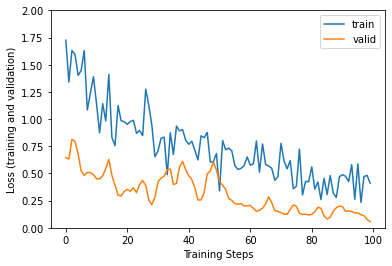

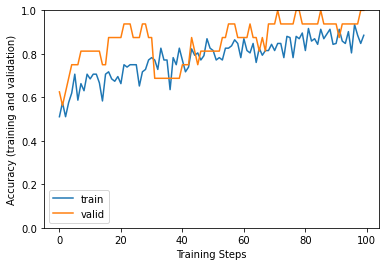

In [12]:
# Visualize training process

plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"], label = 'train')
plt.plot(hist["val_loss"], label = 'valid')
plt.legend()

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"], label = 'train')
plt.plot(hist["val_accuracy"], label = 'valid')
plt.legend()

In [14]:
# 載入模型
net_final = load_model('GF1_model5_resnet50_0121.h5')

# 開啟影像讀取器
test_datagen = ImageDataGenerator()

# 測試數據集路徑
test_dir = r"D:\231219 MAP\231219 GF1\test"

# 測試數據集生成器
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

# 輸出各類別的標籤值
for cls, idx in test_generator.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))
    
# 使用測試資料評估模型指標
scores = net_final.evaluate(test_generator, steps=len(test_generator))
print("Accuracy: %.2f%%" % (scores[1]*100))

Found 34 images belonging to 2 classes.
Class #0 = not reworkable
Class #1 = reworkable
2/2 [==============================] - 1s 14ms/step - loss: 0.5937 - accuracy: 0.8824
Accuracy: 88.24%


In [15]:
# 輸出預測結果
import numpy as np
pred = net_final.predict(test_generator, steps=len(test_generator), verbose=1)
predicted_class_indices = np.argmax(pred, axis=1)
print(predicted_class_indices)

2/2 [==============================] - 1s 297ms/step
[0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1]
